# Import lib

In [1]:
import requests
import pandas as pd
import folium
import time
import random
import matplotlib.pyplot as plt
import datetime
import pprint

In [2]:
#1 choisir une ville par numero de departement
#2 afficher la population de la ville comme un fun fact (avec une ampoule à coté)
#3 récupérer la liste des piezomètres avec l'opération 'station'
#4 afficher la position des n piézomètre
#5 Selectionner un piezomètre
#6 afficher les courbe de la chronique avec l'opération 'chronique'

# Recuperer le code Inses

In [3]:
def recup_commune(departement):
    #addresse api
    curl = f'https://geo.api.gouv.fr/communes?codePostal={str(departement)}'
    #requete api
    commune_req = requests.get(curl).json()
    
    #json
    commune = commune_req[0]
    
    #info
    insee = commune['code']
    ville = commune['nom']
    population = commune['population']
    
    return insee, ville, population

In [4]:
departement = 67000

insee, ville, population = recup_commune(departement)

print("{} possède une population de {:,.0f} habitants".format(ville, population))

Strasbourg possède une population de 287,228 habitants


# Recuperer la liste des stations

In [5]:
def recup_list_stations(insee, ville):
    #code de la ville
    insee_str = str(insee)
    #url pour la requete
    station_url = f'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/stations?code_commune={insee_str}&format=json&size=20&pretty'
    station_req = requests.get(station_url).json()
    #list des stations piezometriques
    stations = station_req['data']

    print(f"il y a {len(stations)} station(s) à {ville}")
    
    return station_req, stations

In [6]:
station_req, stations = recup_list_stations(insee, ville)

il y a 20 station(s) à Strasbourg


# Choisir une station

In [7]:
def print_station_date(station):
    #information pour être print
    n_mesures = station['nb_mesures_piezo']
    date_debut = station['date_debut_mesure']
    date_fin = station['date_fin_mesure']
    
    #recupère date sous format Timestamp
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)
    
    #calcul deltat 
    delta_t = date_fin - date_debut
    delta_t_an = delta_t.days / 365
    delta_t_mois = delta_t.days / 30
    
    #mise en forme
    delta_t_str = "{:.2f}".format(delta_t_an)
    moy = n_mesures/(delta_t_mois) #permet d'avoir une idée de la résolution temporelle du graphique
    moy_str = "{:.2f} mesures/mois".format(moy)
    
    #mise en forme des dates debut et fin
    date_debut_str = date_debut.strftime("%Y-%m-%d")
    date_fin_str = date_fin.strftime("%Y-%m-%d")
    
    print(f"il y a {n_mesures} mesures | {date_debut_str} -> {date_fin_str} ({delta_t_str} ans) | moyenne = {moy_str}")

## Celle qui a le plus de mesures

In [8]:
def station_max_mesure(stations):
    mesure_max = 0
    code_bss = ''
    station = {}

    for s in stations:
        mesures = s['nb_mesures_piezo']
        if mesures > mesure_max:
            mesure_max = mesures
            code_bss = s['code_bss']
            station = s
    
    print(f"la station {code_bss} possède le plus de mesure avec {mesure_max} mesures.")
    
    return station

station = station_max_mesure(stations)

la station 02723X0900/245R1 possède le plus de mesure avec 1682 mesures.


In [9]:
print_station_date(station)

il y a 1682 mesures | 1988-06-16 -> 2022-02-22 (33.71 ans) | moyenne = 4.10 mesures/mois


## une au hasard

In [10]:
def random_station(stations):
    n_stations = len(stations) - 1
    idx = random.randint(0,n_stations)

    station = stations[idx]
    
    print_station_date(station)
    
    return station

station_hasard = random_station(stations)

il y a 596 mesures | 1968-11-12 -> 1997-01-13 (28.19 ans) | moyenne = 1.74 mesures/mois


## Faire une liste

In [11]:
df_stations = pd.DataFrame(stations) 
pd.set_option('display.max_columns', None)

In [56]:
cols = ['code_bss', 'date_debut_mesure', 'date_fin_mesure', 'x', 'y', 'nb_mesures_piezo', 'date_maj']
df_stations_light = df_stations[cols]
df_stations_light.head(2)

,code_bss,date_debut_mesure,date_fin_mesure,x,y,nb_mesures_piezo,date_maj
0,02723X0255/SOC10,1969-05-10,1985-12-16,7.783675,48.594645,250,Wed Apr 22 20:39:08 CEST 2020
1,02723X0110/S20,1971-01-12,1971-08-31,7.779212,48.528374,30,Wed Apr 22 20:39:08 CEST 2020


In [57]:
def return_list_position(df_stations):

    positions_df = df_stations[['y', 'x', 'nb_mesures_piezo']]

    list_positions = []
    labels = []

    for i in positions_df.index:
        lon = positions_df.iloc[i, 0]
        lat = positions_df.iloc[i, 1]
        nbre_mesure = positions_df.iloc[i, 2]

        loc = (lon, lat)

        list_positions.append(loc)
        labels.append(nbre_mesure)
        
    return list_positions, labels

In [64]:
from ipyleaflet import Map, Marker

positions, labels = return_list_position(df_stations)

center = positions[0]

m = Map(center=center, zoom=10)

for loc in positions:
    marker = Marker(location=loc, draggable=False)
    m.add_layer(marker)

m

Map(center=[48.594645, 7.783675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

# Recup la chronique de la station

In [15]:
def recup_chronique(code_bss, size=5000):
    
    chronique_url = f'https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques?code_bss={code_bss}&size={str(size)}'

    chronique_req = requests.get(chronique_url).json()
    chroniques = chronique_req['data']
    print(f"il y a {len(chroniques)} mesure(s)")
    
    return chronique_req, chroniques

In [16]:
code_bss = str(station['code_bss'])

chronique_req, chroniques = recup_chronique(code_bss, size=500)

il y a 500 mesure(s)


In [17]:
chronique_req.keys()

dict_keys(['count', 'first', 'last', 'prev', 'next', 'api_version', 'data'])

In [18]:
chroniques[0]

{'code_bss': '02723X0900/245R1',
 'urn_bss': 'http://services.ades.eaufrance.fr/pointeau/02723X0900/245R1',
 'date_mesure': '1988-06-16',
 'timestamp_mesure': 582422400000,
 'niveau_nappe_eau': 135.69,
 'mode_obtention': 'Valeur mesurée',
 'statut': 'Donnée contrôlée niveau 1',
 'qualification': 'Correcte',
 'code_continuite': '2',
 'nom_continuite': 'Point lié au point précédent',
 'code_producteur': '40494388800036',
 'nom_producteur': 'APRONA (40494388800036)',
 'code_nature_mesure': None,
 'nom_nature_mesure': None,
 'profondeur_nappe': 5.81}

<AxesSubplot:xlabel='date_mesure'>

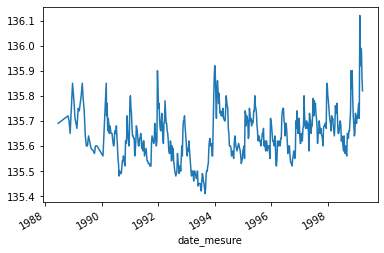

In [19]:
#transformation chroniques -> df time series

#chroniques (list) -> df
df_chronique = pd.DataFrame(chroniques)
# df -> .csv
df_chronique.to_csv('data.csv', index=False)
# csv -> df time series
df = pd.read_csv('data.csv', index_col='date_mesure', parse_dates=True)
#plot
df['niveau_nappe_eau'].plot()